# MLP Neural Net Notebook
This python notebook is used to demonstrate a Multi-Layer  perceptron neural Net architecture
for regression and classification tasks of the [Wine Qaulity dataset](https://archive.ics.uci.edu/dataset/186/wine+quality)

A replica of this functionality is also ported to C# .Net 

### Imports

In [1]:
import pandas as pd
import numpy as np
import math
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from typing import Dict, Tuple, List, Any, Optional
import sys
import enum
from tqdm.notebook import trange, tqdm
from tqdm.notebook import tqdm_notebook
from collections import namedtuple
%matplotlib inline

### Global constants

In [7]:
#DATA_FILE_PATH = "../data/winequality-red.csv"
DATA_FILE_PATH = "../data/uci_auto_mpg_dataset.csv"
DATA_ALL_COLS_LOCAL_FILE_PATH = "../data/uci_auto_mpg_dataset_all_cols.csv"
performance_plot_details = namedtuple(
    "performance_plot_details",["problem_title", "feature_dim_index", "feature_dim_name", "response" ]
)
PERFORMANCE_PLOT_DETAILS = performance_plot_details("UCI Auto MPG prediction", 1, "Horsepower", "MPG")
FILE_DELIMITER = ";"
TRAIN_VALID_SPLIT_FRACTION = 0.80
VALID_SPLIT_FRACTION = 0.20
TEST_SPLIT_FRACTION = 1.0 - TRAIN_VALID_SPLIT_FRACTION
IS_SHUFFLE_DATA = True
NEURAL_NET_TOPOLOGY_FILENAME = "../resources/regression_neural_net.png"

### Enumerations
 - Task type enums

In [3]:
class TaskType(enum.Enum):
    regression = 1
    classification = 2

### Get the ML task dataset
 - Read the dataset from the store (csv file)
 - Move the response column to the end of the dataframe
 - Extract feature dataset (X) and response/labels (y)

In [11]:
data_df = pd.read_csv(DATA_ALL_COLS_LOCAL_FILE_PATH, sep=FILE_DELIMITER)
new_data_df = data_df.copy()
response_df = new_data_df.pop(PERFORMANCE_PLOT_DETAILS.response)
new_data_df[PERFORMANCE_PLOT_DETAILS.response] = response_df.values
X = new_data_df.values[:, :-1]
y = new_data_df.values[:, -1].reshape(-1,1)

In [12]:
#data_df.head(5)
new_data_df.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA,MPG
0,8,307.0,130.0,3504.0,12.0,70,0,0,1,18.0
1,8,350.0,165.0,3693.0,11.5,70,0,0,1,15.0
2,8,318.0,150.0,3436.0,11.0,70,0,0,1,18.0
3,8,304.0,150.0,3433.0,12.0,70,0,0,1,16.0
4,8,302.0,140.0,3449.0,10.5,70,0,0,1,17.0


In [13]:
new_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6


In [14]:
X[:5]

array([[8.000e+00, 3.070e+02, 1.300e+02, 3.504e+03, 1.200e+01, 7.000e+01,
        0.000e+00, 0.000e+00, 1.000e+00],
       [8.000e+00, 3.500e+02, 1.650e+02, 3.693e+03, 1.150e+01, 7.000e+01,
        0.000e+00, 0.000e+00, 1.000e+00],
       [8.000e+00, 3.180e+02, 1.500e+02, 3.436e+03, 1.100e+01, 7.000e+01,
        0.000e+00, 0.000e+00, 1.000e+00],
       [8.000e+00, 3.040e+02, 1.500e+02, 3.433e+03, 1.200e+01, 7.000e+01,
        0.000e+00, 0.000e+00, 1.000e+00],
       [8.000e+00, 3.020e+02, 1.400e+02, 3.449e+03, 1.050e+01, 7.000e+01,
        0.000e+00, 0.000e+00, 1.000e+00]])

In [15]:
y[:5]

array([[18.],
       [15.],
       [18.],
       [16.],
       [17.]])

### Preprocess dataset
 - Split data into train, validation and test datasets

In [16]:
def splitDataset(
    X: np.ndarray, 
    y: np.ndarray,    
    is_shuffle: bool = IS_SHUFFLE_DATA
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X_copy = X.copy()
    y_copy = y.copy()
    n_all_rows = X.shape[0]
    n_train_valid_rows = int(TRAIN_VALID_SPLIT_FRACTION * n_all_rows)
        
    if is_shuffle:
        X_copy = np.random.permutation(X_copy)
        y_copy = np.random.permutation(y_copy)
        
    X_train_valid = X_copy[:n_train_valid_rows, :]
    X_test = X_copy[n_train_valid_rows:, :]
    
    y_train_valid = y_copy[:n_train_valid_rows, :]
    y_test = y_copy[n_train_valid_rows:, :]

    return (X_train_valid, X_test, y_train_valid, y_test)

X_train_valid, X_test, y_train_valid, y_test = splitDataset(X, y)
print(f"X_train_valid:\n{X_train_valid[:5]}\nX_test:\n{X_test[:5]}\n")
print(f"y_train_valid:\n{y_train_valid[:5]}\ny_train_valid:\n{y_test[:5]}\n")



X_train_valid:
[[8.000e+00 3.400e+02 1.600e+02 3.609e+03 8.000e+00 7.000e+01 0.000e+00
  0.000e+00 1.000e+00]
 [8.000e+00 3.510e+02 1.530e+02 4.154e+03 1.350e+01 7.100e+01 0.000e+00
  0.000e+00 1.000e+00]
 [4.000e+00 1.200e+02 7.900e+01 2.625e+03 1.860e+01 8.200e+01 0.000e+00
  0.000e+00 1.000e+00]
 [8.000e+00 3.830e+02 1.700e+02 3.563e+03 1.000e+01 7.000e+01 0.000e+00
  0.000e+00 1.000e+00]
 [4.000e+00 9.800e+01 7.000e+01 2.120e+03 1.550e+01 8.000e+01 0.000e+00
  0.000e+00 1.000e+00]]
X_test:
[[8.000e+00 3.830e+02 1.800e+02 4.955e+03 1.150e+01 7.100e+01 0.000e+00
  0.000e+00 1.000e+00]
 [4.000e+00 8.500e+01 7.000e+01 1.990e+03 1.700e+01 7.600e+01 0.000e+00
  1.000e+00 0.000e+00]
 [4.000e+00 1.400e+02 9.000e+01 2.264e+03 1.550e+01 7.100e+01 0.000e+00
  0.000e+00 1.000e+00]
 [4.000e+00 1.340e+02 9.500e+01 2.560e+03 1.420e+01 7.800e+01 0.000e+00
  1.000e+00 0.000e+00]
 [8.000e+00 3.180e+02 1.450e+02 4.140e+03 1.370e+01 7.700e+01 0.000e+00
  0.000e+00 1.000e+00]]

y_train_valid:
[[38. ]
 

### MLP Neural Net
 - Class encpasulating the functionality of a MLP neural net

In [23]:
class MLPNeuralNet:
    def __init__(
        self,
        X: np.array,
        y: np.array,
        network_topology: Dict[str, Any],
        network_params: Dict[str, Any],
        task_type: TaskType = TaskType.regression
    ):
        """
        Constructor
        """
        print("Constructing the MLP neural network ..")
        self._X_train_valid, self._X_test, self._y_train_valid, self._y_test = splitDataset(X, y)
        self._n_features = self._X_train_valid.shape[1]
        self._n_nodes_per_hidden_layer = network_topology["n_nodes_per_hidden_layer"]
        self._n_layers = len(self._n_nodes_per_hidden_layer)        
        self._optimizer_type = network_params["optimizer_type"]
        self._hidden_activation_function = network_params["hidden_activation_function"]
        self._batch_size = network_params["batch_size"]
        self._n_epochs = network_params["n_epochs"]
        self._validation_split = network_params["validation_split"]
        self._loss_function = network_params["loss_function"]
        self._performance_function = network_params["performance_metric"]
        self._task_type = task_type
        self._early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        self._normalizer = self.createNormalizer()
                
        self._model = None
        self._history = None
        self._train_accuracy = None
        self._valid_accuracy = None
        self._train_loss = None
        self._valid_loss = None
        self._test_results = dict()
        

    def createNormalizer(self) -> Any:
        """
        Create the data normalizer
        """
        normalizer = tf.keras.layers.Normalization(input_dim=self._X_train_valid.shape[1], axis=-1)
        normalizer.adapt(np.array(self._X_train_valid))
        return normalizer
        

    def _createMultipleHiddenLayerNN(self):
        """
        Creates a multiple hidden layer NN topology
        """
        self._model = tf.keras.Sequential()
        self._model.add(self._normalizer)
        self._model.add(tf.keras.layers.Dense(
            units=self._n_nodes_per_hidden_layer[0],
            # input_shape=(self._n_features,), 
            activation=self._hidden_activation_function)
        )
        if len(self._n_nodes_per_hidden_layer) > 1:
            for n_hidden_nodes in self._n_nodes_per_hidden_layer[1:]:
                self._model.add(tf.keras.layers.Dense(n_hidden_nodes, activation=self._hidden_activation_function))
        self._model.add(tf.keras.layers.Dense(1,))
        self._model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss ='mean_absolute_error', 
            metrics=[self.rSquared])
        return self._model

    def createNeuralNetModel(self):
        """
        Creates the Multi-Layer Perceptron Neural Net
        """
        print("Creating the neural network..")
        self._model = self._createMultipleHiddenLayerNN()
        self.visualizeNeuralNetwork()

    def rSquared(
        self, 
        y: Any, 
        y_hat: Any
    ) -> Any:
        """
        Method computes the coefficient of goodness (R^2) metric
        :param y: Actaul response
        :param y_hat: Predicted response
        :return: Returns the R^2 metric
        """
        #print(f"y: {tf.print(y)}\ty_hat: {tf.print(y_hat)}")
        residual = tf.reduce_sum(tf.square(tf.subtract(y, y_hat)))
        total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
        r2 = tf.subtract(1.0, tf.divide(residual, total))
        return r2

    def trainRegressionModel(self):
        """
        Computes the training cycle for regression problem using a neural network model
        """
        self._history = self._model.fit(
            self._X_train_valid,
            self._y_train_valid,
            epochs=self._n_epochs, 
            # batch_size=self._batch_size,
            validation_split=self._validation_split,
            # callbacks=[self._early_stop]
            )
        self._train_accuracy = self._model.history.history["rSquared"]
        self._valid_accuracy = self._model.history.history["val_rSquared"]
        self._train_loss = self._model.history.history["loss"]
        self._valid_loss = self._model.history.history["val_loss"]
        return {
            "rSquared": self._train_accuracy,
            "val_rSquared": self._valid_accuracy,
            "loss": self._train_loss,
            "val_loss": self._valid_loss
        }

    def predict(
            self, 
            X_hat: np.array
        ) -> np.array:
        """
        Predict the call price using the model
        :param X_hat: Input features
        """
        y_hat = self._model.predict(X_hat, batch_size=self._batch_size)
        return y_hat

    def evaluate(self) -> Dict[str, float]:
        """
        Evaluate the MLP model
        """
        self._test_results['mlp_model'] = self._model.evaluate(self._X_test, self._y_test, verbose=0)
        return self._test_results

    def visualizeModelLossAndAccuracy1(self):
        """
        Plots the model loss and accuracy results
        """
        plt.figure(figsize=(14,5))
        epochs = np.array(range(len(self._train_accuracy)))
        
        plt.subplot(1,2,1)
        plt.plot(epochs, self._train_accuracy, 'b^',  label="Training accuracy")
        plt.plot(epochs, self._valid_accuracy, 'y*', label="Validation accuracy")
        plt.ylabel("R^2")
        plt.xlabel("Epoch")
        plt.title("R^2 Performance metric")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(epochs, self._train_loss, 'b^', label="Training loss",)
        plt.plot(epochs, self._valid_loss, 'y*', label="Validation loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.title("MAE Performance metric")
        plt.legend()
        plt.show()

    def visualizeModelLossAndAccuracy(self):
      plt.plot(self._model.history.history['loss'], label='loss')
      plt.plot(self._model.history.history['val_loss'], label='val_loss')
      plt.ylim([0, 10])
      plt.xlabel('Epoch')
      plt.ylabel('Error [MPG]')
      plt.legend()
      plt.grid(True)

    def visualizeNeuralNetwork(self):
        """
        Method is used to visualize the created neural network structure/topology
        """
        print("Neural Network topology:\n\n")
        self._model.summary()
        plot_model(
            self._model, 
            to_file=NEURAL_NET_TOPOLOGY_FILENAME, 
            show_shapes=True, show_layer_names=True
        )
        print(f"\nThe detailed Neural Network topology has been generated and can be found here: '{NEURAL_NET_TOPOLOGY_FILENAME}'")

    def visualizePrediction(
        self
    ):
        """
        Plots the results of the prediction
        :param X_feature_dim: X feature dimension
        """
        plot_title = PERFORMANCE_PLOT_DETAILS.problem_title        
        plt.figure(figsize=(14,5))
        y_predicted = self.predict(self._X_test)
        y_true = self._y_test
        # print(f"y_predicted[:5]: {y_predicted[:25]}\ty_true[:5]: {y_true[:25]}")
        a = plt.axes(aspect='equal')
        plt.scatter(y_true, y_predicted)
        plt.xlabel('True Values [MPG]')
        plt.ylabel('Predictions [MPG]')
        plt.title(plot_title)
        lims = [0, 50]
        plt.xlim(lims)
        plt.ylim(lims)
        _ = plt.plot(lims, lims)
        

        
    

### Neural Network configurations

In [24]:
neural_network_topology = {
    #"n_nodes_per_hidden_layer": [10], 
    "n_nodes_per_hidden_layer": [64, 64],       
}

neural_network_params = {
    "optimizer_type": "adam",
    "hidden_activation_function": "relu",    
    "batch_size": 128,
    "n_epochs": 200,
    "validation_split": VALID_SPLIT_FRACTION,
    "loss_function": "mae",
    "performance_metric": "accuracy"    
}


### Run "regression" task MLP neural net prediction problem 


Run of the Neural Net regression task
X.shape: (392, 9)	y.shape: (392, 1)
Constructing the MLP neural network ..
Creating the neural network..
Neural Network topology:


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                640       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
____________

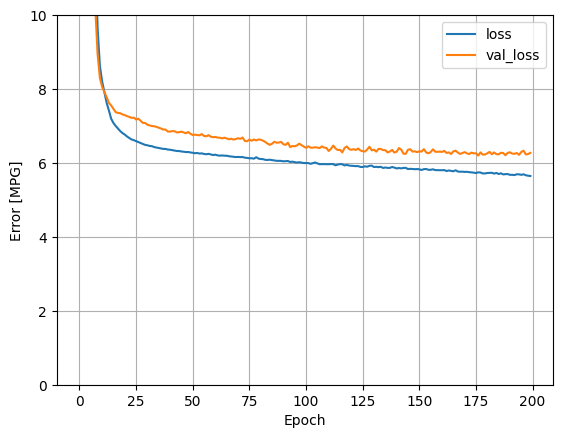

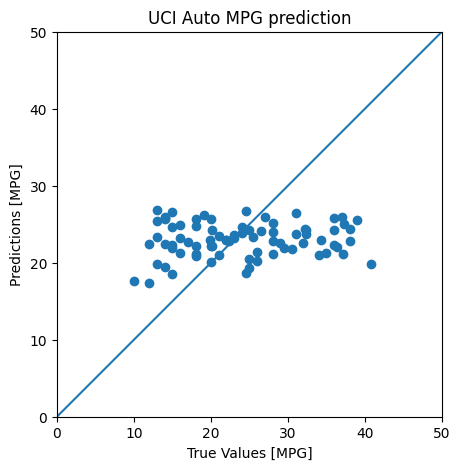

In [25]:
def runMLPNeuralNetRegressionTask():
    """
    Runs the Neural Net regression task
    """
    print(f"\nRun of the Neural Net regression task")
    print(f"X.shape: {X.shape}\ty.shape: {y.shape}")
    nn_model = MLPNeuralNet(
        X=X,
        y=y,
        network_topology=neural_network_topology,
        network_params=neural_network_params,
        task_type=TaskType.regression
    )
    nn_model.createNeuralNetModel()
    train_metrics = nn_model.trainRegressionModel()
    valid_r_squared = np.round(train_metrics["val_rSquared"][-1], 4)
    valid_mae = np.round(train_metrics["val_loss"][-1], 4)
    print(f"NN Training metrics:")
    print(f"Validated R^2: {valid_r_squared}")
    print(f"Validated MAE loss: {valid_mae}")
    print("\n\n")
    nn_model.visualizeModelLossAndAccuracy()
    nn_model.visualizePrediction()
    test_result = nn_model.evaluate()
    print(f"Performance summary results are:\n{test_result}\n")
    # nn_model.visualizePrediction(X_test=X_test, y_test=y_test, use_time_horizon=False)
    

runMLPNeuralNetRegressionTask()

In [ ]:
list(PERFORMANCE_PLOT_FEATURE.values())[0]